In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145118 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import Model, load_model
import numpy as np
from matplotlib import pyplot as plt
import os
from math import log
import pickle

In [0]:
def read_file(path):
  content = None
  with open(path) as f:
    content = f.read()
  return content

In [0]:
vocab = read_file('/content/drive/Image Captioning/Utility Data/vocabulary.txt')
vocab = eval(vocab)

captions = read_file('/content/drive/Image Captioning/Utility Data/captions.txt')
captions = eval(captions)

train_captions = read_file('/content/drive/Image Captioning/Utility Data/train_captions.txt')
train_captions = eval(train_captions)

In [0]:
train_images = None
with open('/content/drive/Image Captioning/Utility Data/train_images.pkl', 'rb') as f:
  train_images = pickle.load(f)

In [0]:
def create_mapping(vocab):
  word_to_index = {} 
  index_to_word = {}
  for index, word in enumerate(vocab):
    word_to_index[word] = index + 1 
    index_to_word[index + 1] = word
  index = len(word_to_index)
  word_to_index['<start>'] = index + 1
  index_to_word[index + 1] = '<start>'
  word_to_index['<end>'] = index + 2
  index_to_word[index + 2] = '<end>'
  return word_to_index, index_to_word

In [0]:
word_to_index, index_to_word = create_mapping(vocab)

In [0]:
def maximum_length(captions):
  max_length = 0
  for k in captions.keys():
    for caption in captions[k]:
      max_length = max(max_length, len(caption.split()))
  return max_length

In [0]:
def create_embedding(vocab, word_to_index):
  embedding = {}
  with open('/content/drive/Image Captioning/glove.6B.50d.txt') as f:
    for line in f:
      values = line.split()
      word = values[0]
      word_embedding = np.array(values[1:], dtype = 'float')
      embedding[word] = word_embedding
  embedding_dims = 50
  embedding_matrix = np.zeros((len(vocab) + 3, embedding_dims))
  for word in vocab:
    if word in embedding.keys():
      embedding_matrix[word_to_index[word]] = embedding[word]
  return embedding_matrix

In [0]:
embedding_matrix = create_embedding(vocab, word_to_index)

In [0]:
def data_generator(train_captions, train_images, word_to_index, max_length, batch_size):
  X1, X2, Y = [], [], []
  size = 1
  while True:
    for image_id, caption_list in train_captions.items():
      try:
        image = train_images[image_id]
      except:
        continue
      for caption in caption_list:
        sequence = [word_to_index[word] for word in caption.split() if word in word_to_index]
        for i in range(1, len(sequence)):
          xi = sequence[0:i]
          yi = sequence[i]
          xi = pad_sequences([xi], maxlen = max_length, value = 0, padding = 'post')[0]
          yi = to_categorical([yi], num_classes = len(vocab) + 3)[0]
          X1.append(image)
          X2.append(xi)
          Y.append(yi)
        if size == batch_size:
          yield [[np.array(X1), np.array(X2)], np.array(Y)]
          X1, X2, Y = [], [], []
          size = 1
      size += 1

In [0]:
def build_model(embedding_matrix, max_length, vocab_size, embedding_dims):
  image_input = Input(shape = (2048, ))
  L1 = Dropout(0.3)(image_input)
  image_encoding = Dense(256, activation = 'relu')(L1)
  
  caption_input = Input(shape = (max_length, ))
  L2 = Embedding(input_dim = vocab_size + 3, output_dim = embedding_dims, mask_zero = True)(caption_input)
  L3 = Dropout(0.3)(L2)
  caption_encoding = LSTM(256)(L3)
  
  decoder = add([image_encoding, caption_encoding])
  L4 = Dense(256, activation = 'relu')(decoder)
  output = Dense(vocab_size + 3, activation = 'softmax')(L4)
  
  model = Model(inputs = [image_input, caption_input], outputs = output)
  model.layers[2].set_weights([embedding_matrix])
  model.layers[2].trainable = False
  return model

In [0]:
def train(train_captions, train_images, word_to_index, max_length, num_epochs = 10, batch_size = 3):
  history = None
  for epoch in range(num_epochs):
    generator = data_generator(train_captions, train_images, word_to_index, max_length, batch_size)
    history = model.fit_generator(generator, epochs = 1, steps_per_epoch = len(train_captions) // batch_size, verbose = 1)
    model.save('/content/drive/Image Captioning/Model Weights/model_weights_' + str(epoch) + '.h5')
  return history

In [15]:
model = build_model(embedding_matrix, maximum_length(captions), len(vocab), 50)
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 38, 50)       92900       input_2[0][0]                    
_______________________________________________________________________

In [16]:
model = load_model('/content/drive/Image Captioning/Model Weights/model_weights_9.h5')
adam = Adam(lr = 0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam)

In [17]:
max_len = maximum_length(captions)
history = train(train_captions, train_images, word_to_index, max_len)

Epoch 1/1
2427/2427 [==============================] - 215s 89ms/step - loss: 1.5908
Epoch 1/1
2427/2427 [==============================] - 210s 87ms/step - loss: 1.5896
Epoch 1/1
2427/2427 [==============================] - 210s 87ms/step - loss: 1.5884
Epoch 1/1
2427/2427 [==============================] - 210s 87ms/step - loss: 1.5903
Epoch 1/1
2427/2427 [==============================] - 214s 88ms/step - loss: 1.5878
Epoch 1/1
2427/2427 [==============================] - 202s 83ms/step - loss: 1.5864
Epoch 1/1
2427/2427 [==============================] - 199s 82ms/step - loss: 1.5884
Epoch 1/1
2427/2427 [==============================] - 199s 82ms/step - loss: 1.5871
Epoch 1/1
2427/2427 [==============================] - 196s 81ms/step - loss: 1.5835
Epoch 1/1
2427/2427 [==============================] - 196s 81ms/step - loss: 1.5856


In [0]:
def predict(image, beam_width = 3, alpha = 0.7):
  l = [('<start>', 1.0)]
  for i in range(max_len):
    temp = []
    for j in range(len(l)):
      sequence = l[j][0]
      prob = l[j][1]
      if sequence.split()[-1] == '<end>':
        t = (sequence, prob)
        temp.append(t)
        continue
      encoding = [word_to_index[word] for word in sequence.split() if word in word_to_index]
      encoding = pad_sequences([encoding], maxlen = max_len, padding = 'post')
      pred = model.predict([image, encoding])[0]
      pred = list(enumerate(pred))
      pred = sorted(pred, key = lambda x: x[1], reverse = True)
      pred = pred[:beam_width]
      for p in pred:
        t = (sequence + ' ' + index_to_word[p[0]], (prob + log(p[1])) / ((i + 1)**alpha))
        temp.append(t)
    temp = sorted(temp, key = lambda x: x[1], reverse = True)
    l = temp[:beam_width]
  caption = l[0][0]
  caption = caption.split()[1:-1]
  caption = ' '.join(caption)
  return caption

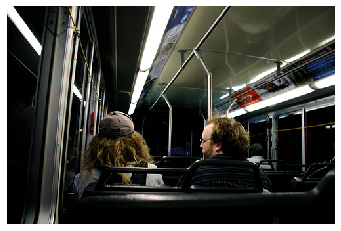

Actual caption:  a man sits next to a woman on a bus .
Predicted caption:  a man and woman sit on a train in a subway station .


In [35]:
index = np.random.randint(len(train_images))
image_name = list(train_images.keys())[index]
encoding = train_images[image_name]
encoding = encoding.reshape((1, encoding.shape[0]))
image = plt.imread(os.path.join('/content/drive/Image Captioning/Dataset/Flicker8k_Dataset', image_name + '.jpg'))
plt.imshow(image)
plt.axis('off')
plt.show()
actual_caption = captions[image_name]
print('Actual caption: ', actual_caption[0])
predicted_caption = predict(encoding)
print('Predicted caption: ', predicted_caption)

In [0]:
test_images = None
with open('/content/drive/Image Captioning/Utility Data/test_images.pkl', 'rb') as f:
  test_images = pickle.load(f)

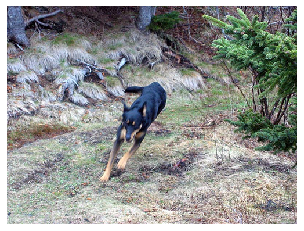

Actual caption:  a black dog running .
Predicted caption:  a black and brown dog is running through the woods .


In [50]:
index = np.random.randint(len(test_images))
image_name = list(test_images.keys())[index]
encoding = test_images[image_name]
encoding = encoding.reshape((1, encoding.shape[0]))
image = plt.imread(os.path.join('/content/drive/Image Captioning/Dataset/Flicker8k_Dataset', image_name + '.jpg'))
plt.imshow(image)
plt.axis('off')
plt.show()
actual_caption = captions[image_name]
print('Actual caption: ', actual_caption[0])
predicted_caption = predict(encoding)
print('Predicted caption: ', predicted_caption)